In [1]:
import zipfile
zip_file = zipfile.ZipFile('/content/model_test.zip')
zip_file.extractall('/content/')

In [2]:
import pandas as pd
df=pd.read_csv('model_test.csv')
img_list = ['/content/model_test/' + filename for filename in df['filename']]
label = [0 if lbl == 'happy' else 1 for lbl in df['label']]

In [ ]:
import torch
def load_checkpoint(load_path, model,device):
    checkpoint = torch.load(load_path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

    return checkpoint['epoch'], train_losses, val_losses, train_accuracies, val_accuracies

### test_img(model_weight, img_list): 학습한 모델로 test set 평가
- de, eff, res에 따라 각 모델 구조에 맞는 model weight load
- predictions: 예측된 label 반환
- probabilities: label의 확률 반환

In [ ]:
from torchvision import models
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return image, label
        else:
            return image

def test_img(model_weight,img_list):
  if "de" in model_weight:
    model = models.densenet121(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    for param in model.features.denseblock4.parameters():
      param.requires_grad = True

    num_classes = 1
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    for param in model.classifier.parameters():
      param.requires_grad = True

  elif "eff" in model_weight:
    model = models.efficientnet_b0(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False

    for param in model.features[5:].parameters():
      param.requires_grad = True
    num_classes = 1
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    for param in model.classifier.parameters():
      param.requires_grad = True

  elif "res" in model_weight:
    if "18" in model_weight:
      model = models.resnet18(pretrained=True)
    elif "34" in model_weight:
      model = models.resnet34(pretrained=True)

    for param in model.parameters():
      param.requires_grad = False
    for param in model.layer4.parameters():
      param.requires_grad = True
    num_classes = 1
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    for param in model.fc.parameters():
      param.requires_grad = True

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  start_epoch, train_losses, val_losses, train_accuracies, val_accuracies = load_checkpoint(model_weight, model, device)

  model.to(device)
  model.eval()

  test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
  ])

  test_dataset = CustomDataset(img_list, labels=None, transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  predictions=[]
  probabilities = []

  with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).long()
        predictions.extend(predicted.cpu().tolist())
        probabilities.extend(probs.cpu().tolist())

  return predictions,probabilities

### efficientnetb0 - AdamW, ReduceLROnPlateau

In [21]:
pred_eff_ada_re_b,prob_eff_ada_re_b=test_img("eff_ada_re_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

### 성능평가

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def calculate_metrics(label, pred):
  ret=[]
  precision = np.round(precision_score(label, pred),4)
  recall = np.round(recall_score(label, pred),4)
  f1 = np.round(f1_score(label, pred),4)

  print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

  ret.append(precision)
  ret.append(recall)
  ret.append(f1)

  return ret
eff_ada_re_b_met=calculate_metrics(label,pred_eff_ada_re_b)

Precision: 0.9159, Recall: 1.0, F1: 0.9561


### 예측 틀린 이미지 시각화

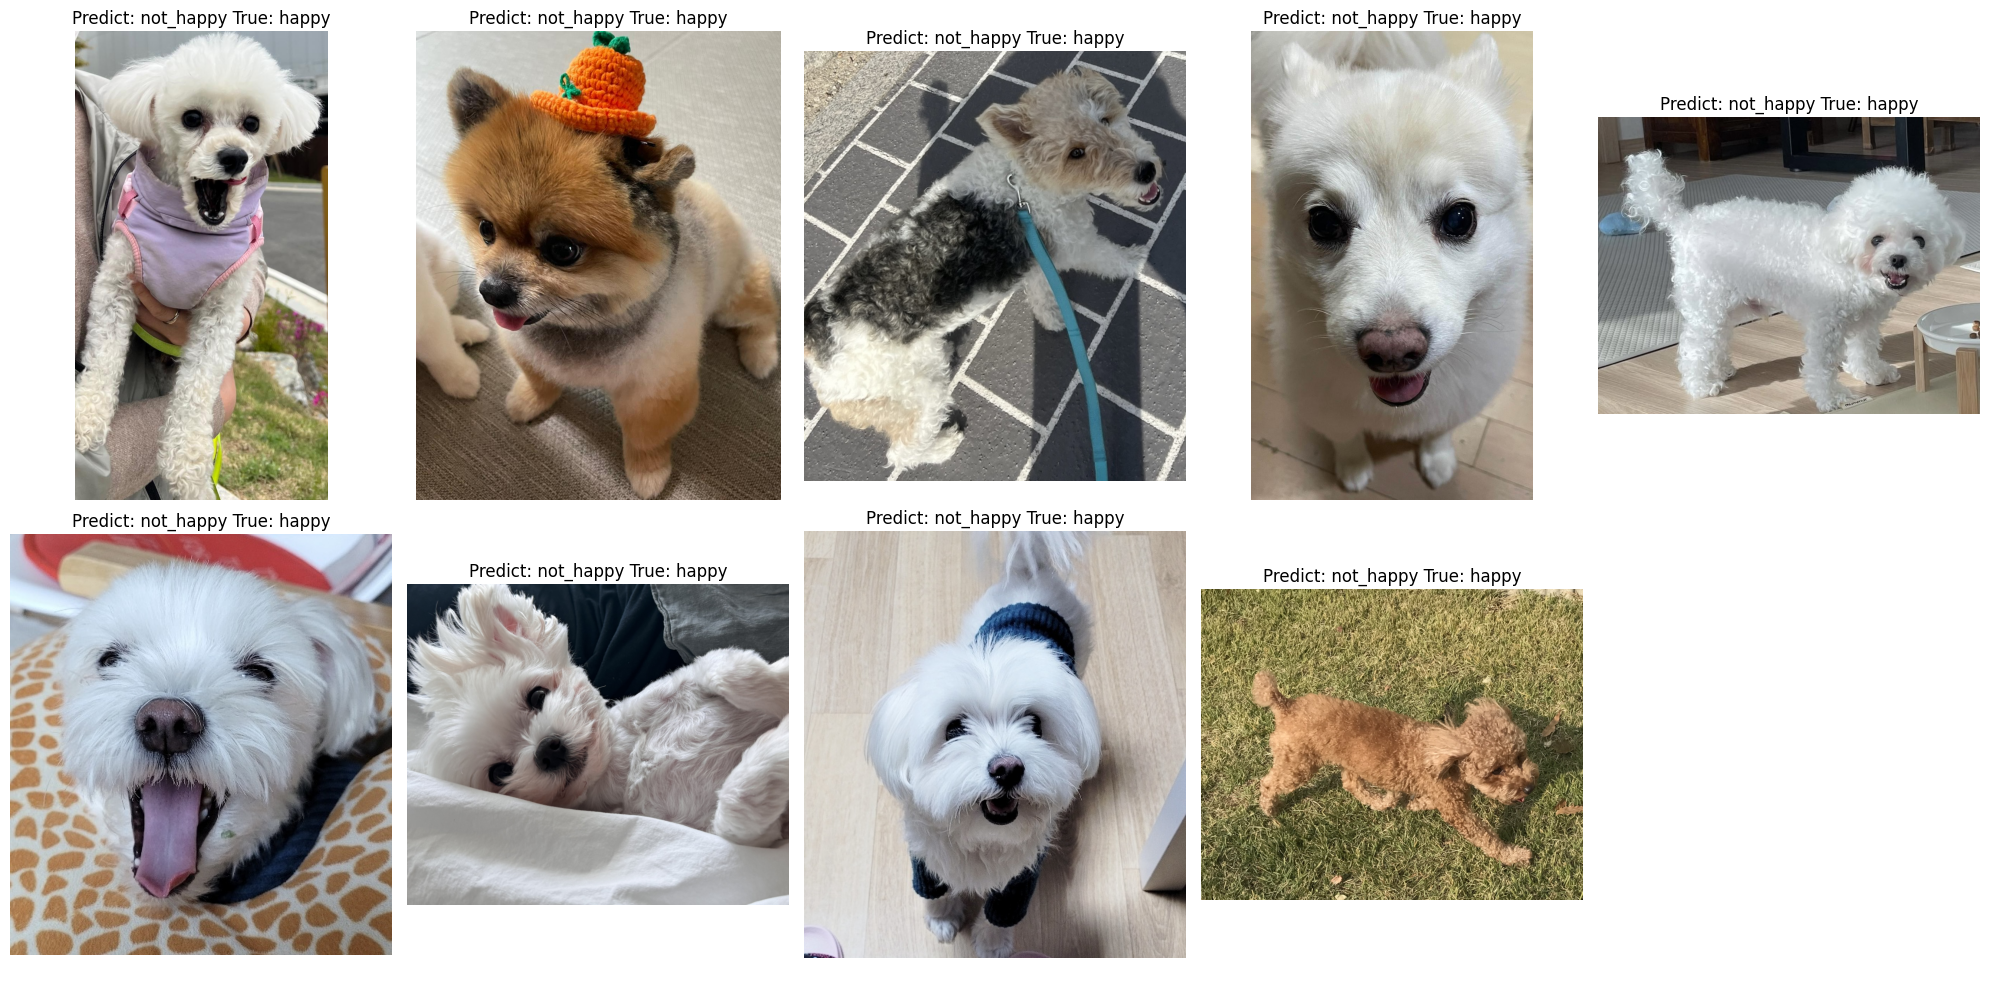

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import os


def show_fpred(label,predict,img_list):
  mismatch_indices = [i for i, (true, pred) in enumerate(zip(label, predict)) if true != pred]
  image_list = [img_list[i] for i in mismatch_indices]
  title_texts = [
    f"Predict: {'happy' if predict[i] == 0 else 'not_happy'} True: {'happy' if label[i] == 0 else 'not_happy'}"
    for i in mismatch_indices
  ]

  num_images = len(image_list)
  rows = (num_images + 4) // 5
  fig, axes = plt.subplots(rows, 5, figsize=(20, rows * 5))

  for idx, (img_path, title) in enumerate(zip(image_list, title_texts)):
    img = Image.open(img_path)
    ax = axes[idx // 5, idx % 5] if rows > 1 else axes[idx % 5]
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis('off')
  for idx in range(len(image_list), rows * 5):
    ax = axes[idx // 5, idx % 5] if rows > 1 else axes[idx % 5]
    ax.axis('off')

  plt.tight_layout()
  plt.show()
  new_image_list = [os.path.basename(path) for path in image_list]
  return new_image_list

mis_eff_ada_re_b=show_fpred(label, pred_eff_ada_re_b, img_list)

### efficientnetb0 - AdamW, ReduceLROnPlateau (early stopping)

In [25]:
pred_eff_ada_re6_b,prob_eff_ada_re6_b=test_img("eff_ada_re_b_epoch_6.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [26]:
eff_ada_re6_b_met=calculate_metrics(label,pred_eff_ada_re6_b)

Precision: 0.9333, Recall: 1.0, F1: 0.9655


### efficientnetb0 - AdamW

In [29]:
pred_eff_ada_b,prob_eff_ada_b=test_img("eff_ada_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [30]:
eff_ada_met_b=calculate_metrics(label,pred_eff_ada_b)

Precision: 0.9462, Recall: 0.898, F1: 0.9215


### efficientnetb0 - AdamW (early stopping)

In [33]:
pred_eff_ada5_b,prob_eff_ada5_b=test_img("eff_ada_b_epoch_5.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [34]:
eff_ada5_met_b=calculate_metrics(label,pred_eff_ada5_b)

Precision: 0.96, Recall: 0.9796, F1: 0.9697


### efficientnetb0 - sgd, CosAnnealingLR

In [37]:
pred_eff_sgd_cos_b,prob_eff_sgd_cos_b=test_img("eff_sgd_cos_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [38]:
eff_sgd_cos_b_met=calculate_metrics(label,pred_eff_sgd_cos_b)

Precision: 0.9406, Recall: 0.9694, F1: 0.9548


### efficientnetb0 - sgd, CosineAnnealingLR (early stopping)

In [41]:
pred_eff_sgd_cos5_b, prob_eff_sgd_cos5_b=test_img("eff_sgd_cos_b_epoch_5.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [42]:
eff_sgd_cos5_b_met=calculate_metrics(label,pred_eff_sgd_cos5_b)

Precision: 0.8673, Recall: 1.0, F1: 0.9289


### efficientnetb0 - sgd

In [45]:
pred_eff_sgd_b,prob_eff_sgd_b=test_img("eff_sgd_b.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [46]:
eff_sgd_b_met=calculate_metrics(label,pred_eff_sgd_b)

Precision: 0.9126, Recall: 0.9592, F1: 0.9353


### efficientb0 - sgd (early stopping)

In [49]:
pred_eff_sgd8_b,prob_eff_sgd8_b=test_img("eff_sgd_b_epoch_8.pth",img_list)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-1fe826eb7837>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [50]:
eff_sgd8_b_met=calculate_metrics(label,pred_eff_sgd8_b)

Precision: 0.9271, Recall: 0.9082, F1: 0.9175


### 데이터프레임으로

In [53]:
data = [
    {"filename": "eff_ada_re_b_met", "precision": eff_ada_re_b_met[0], "recall": eff_ada_re_b_met[1], "f1": eff_ada_re_b_met[2]},
    {"filename": " eff_ada_re6_b_met", "precision":  eff_ada_re6_b_met[0], "recall":  eff_ada_re6_b_met[1], "f1":  eff_ada_re6_b_met[2]},
    {"filename": " eff_ada_b_met", "precision":  eff_ada_met_b[0], "recall":  eff_ada_met_b[1], "f1":  eff_ada_met_b[2]},
    {"filename": "eff_ada5_b_met", "precision": eff_ada5_met_b[0], "recall": eff_ada5_met_b[1], "f1": eff_ada5_met_b[2]},
    {"filename": " eff_sgd_cos_b_met", "precision":  eff_sgd_cos_b_met[0], "recall":  eff_sgd_cos_b_met[1], "f1":  eff_sgd_cos_b_met[2]},
    {"filename": "eff_sgd_cos5_b_met", "precision": eff_sgd_cos5_b_met[0], "recall": eff_sgd_cos5_b_met[1], "f1": eff_sgd_cos5_b_met[2]},
    {"filename": " eff_sgd_b_met", "precision":  eff_sgd_b_met[0], "recall":  eff_sgd_b_met[1], "f1":  eff_sgd_b_met[2]},
    {"filename": " eff_sgd8_b_met", "precision":  eff_sgd8_b_met[0], "recall":  eff_sgd8_b_met[1], "f1":  eff_sgd8_b_met[2]}
]

df = pd.DataFrame(data)

In [54]:
df.to_csv('efficientnet_metrics_new.csv', index=False)

In [59]:
for i in range(len(label)):
  if label[i]==0:label[i]='happy'
  else:label[i]='not_happy'

In [60]:
df_prob = pd.DataFrame({
    'prob_eff_ada_re_b': pd.Series(prob_eff_ada_re_b),
    'prob_eff_ada_re6_b': pd.Series(prob_eff_ada_re6_b),
    'prob_eff_ada_b': pd.Series(prob_eff_ada_b),
    'prob_eff_ada5_b': pd.Series(prob_eff_ada5_b),
    'prob_eff_sgd_cos_b': pd.Series(prob_eff_sgd_cos_b),
    'prob_eff_sgd_cos5_b': pd.Series(prob_eff_sgd_cos5_b),
    'prob_eff_sgd_b': pd.Series(prob_eff_sgd_b),
    'prob_eff_sgd8_b': pd.Series(prob_eff_sgd8_b)
})

In [61]:
df_prob['label']=label

In [62]:
df_prob.head()

,prob_eff_ada_re_b,prob_eff_ada_re6_b,prob_eff_ada_b,prob_eff_ada5_b,prob_eff_sgd_cos_b,prob_eff_sgd_cos5_b,prob_eff_sgd_b,prob_eff_sgd8_b,label
0,0.998873,0.977323,0.987016,0.914689,0.531578,0.975472,0.996696,0.994180,not_happy
1,0.985003,0.941556,0.555269,0.650291,0.922470,0.616789,0.807156,0.175430,not_happy
2,0.000570,0.004761,0.000075,0.000543,0.000816,0.001729,0.007698,0.001345,happy
3,0.999976,0.998533,0.998123,0.994087,0.991994,0.998316,0.999367,0.996304,not_happy
4,0.982146,0.975151,0.975563,0.978752,0.998237,0.998191,0.854671,0.906607,not_happy


In [63]:
df_prob.to_csv('efficientnet_probability_new.csv', index=False)